### Removing eye blink movement from EEG data

Electroencephalography (EEG) data is contaminated by various motion artifacts, which occur by voluntary or involuntary patient movement during image acquisition. A common one is the eye blink movement. Thus, tools such as ICA are widely used techniques to remove these kinds of noise.

 As already discussed, ICA is a way to separate independent contributions of the signal. Hence, intuitively we should expect an important contribution of eye blink movement in channels closer to the eyes.

In [ ]:
pip install mne

MNE library is used for EEG data handling and analysis

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import mne as mne
sns.set_palette('pastel')

eeg = np.loadtxt('/content/OlhosAbertos.txt')
canais = pd.read_csv('/content/NOMEScanais.txt', dtype='str', header=None)

# Suponha que o sinal foi adquirido sob uma taxa de amostragem de 250Hz:
Hz = 250

eeg = pd.DataFrame(eeg, columns=canais.iloc[:,0].values)
eeg['Time(s)'] = np.arange(0, (1/Hz)*len(eeg), 1/Hz)

Creating MNE EEG object

In [4]:
mne_info = mne.create_info(
                    list(eeg.columns[:-1]),
                    Hz,
                    ch_types=['eeg']*len(eeg.columns[:-1])
)

In [5]:
mne_raw = mne.io.RawArray(eeg.iloc[:,:-1].values.T, mne_info)

standard_1020 = mne.channels.make_standard_montage('standard_1020')
mne_raw.set_montage(standard_1020)

Creating RawArray with float64 data, n_channels=32, n_times=45465
    Range : 0 ... 45464 =      0.000 ...   181.856 secs
Ready.


<RawArray | 32 x 45465 (181.9 s), ~11.1 MB, data loaded>

In order to extract just important features, we need to filter the time series to exclude high ( > 120 Hz) and low ( < 4 Hz ) frequencies related to artifacts and noise, and also 60Hz contribution from the environment power line.

In [6]:
# Set filter parameters
lowCut = 4 # Hz
highCut = 120 # Hz
freqNotch = 60 # Hz (eletric interference from the enviroment)

# Apply bandpass and notch filter
mne_raw.filter(lowCut, highCut, fir_design='firwin')
mne_raw.notch_filter(freqNotch, fir_design='firwin')


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 1.2e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 120.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 122.50 Hz)
- Filter length: 413 samples (1.652 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passban

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


<RawArray | 32 x 45465 (181.9 s), ~11.1 MB, data loaded>

Using matplotlib as 2D backend.


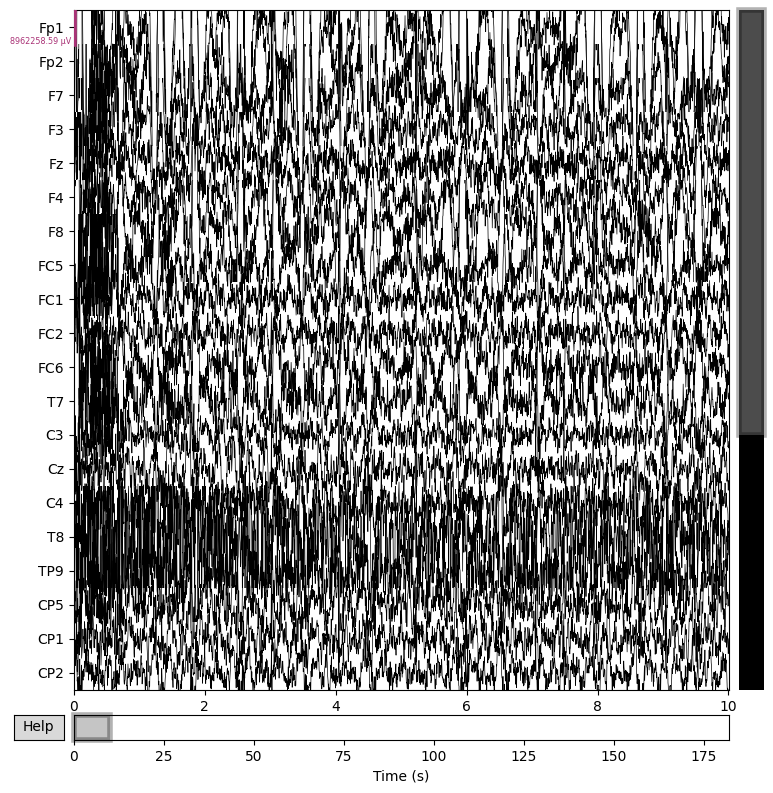

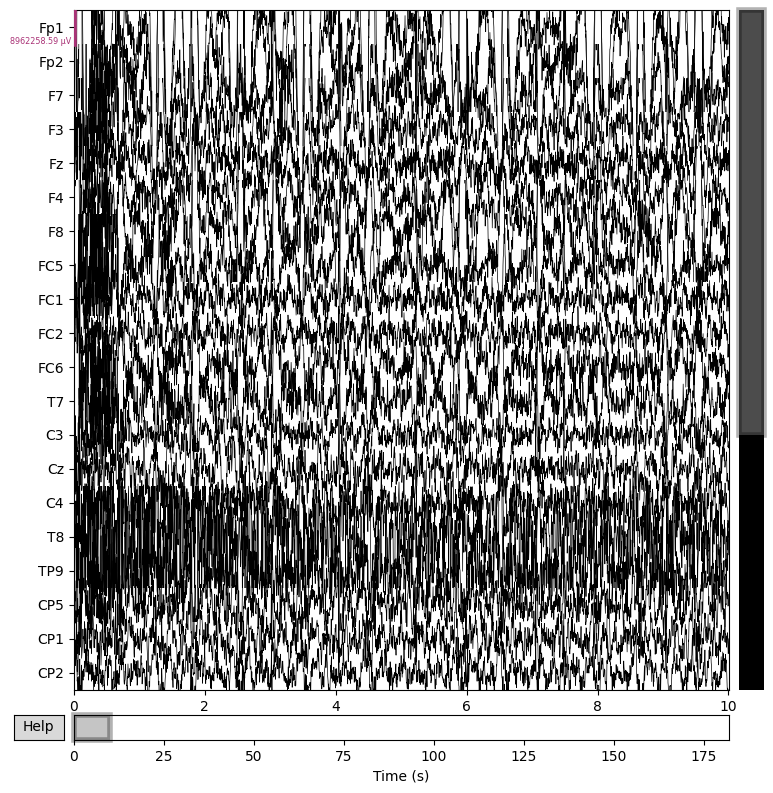

In [7]:
#%matplotlib ipympl
mne_raw.plot(scalings='auto')

Now, the data is ready to go through ICA.

In [8]:
ica_obj = mne.preprocessing.ICA(
                    n_components=0.99,
                    method='infomax',
                    max_iter="auto",
                    random_state=1,
                    fit_params=dict(extended=True)).fit(mne_raw)

ica = ica_obj.get_sources(mne_raw).get_data()
print(ica.shape)

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by explained variance: 25 components
Computing Extended Infomax ICA
Fitting ICA took 23.6s.
(25, 45465)


Creating RawArray with float64 data, n_channels=25, n_times=45465
    Range : 0 ... 45464 =      0.000 ...   181.856 secs
Ready.


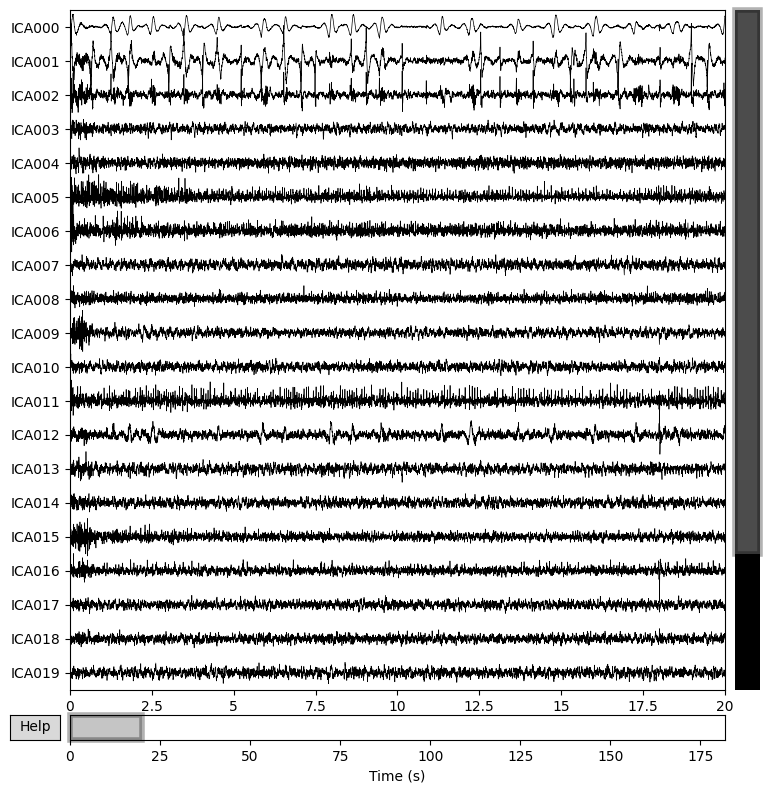

In [9]:
ica_obj.plot_sources(mne_raw);

The ICA coefficients are used as a proxy to identify spatial contribution to the signal component.

Therefore, it's possible to create heat maps for each component.

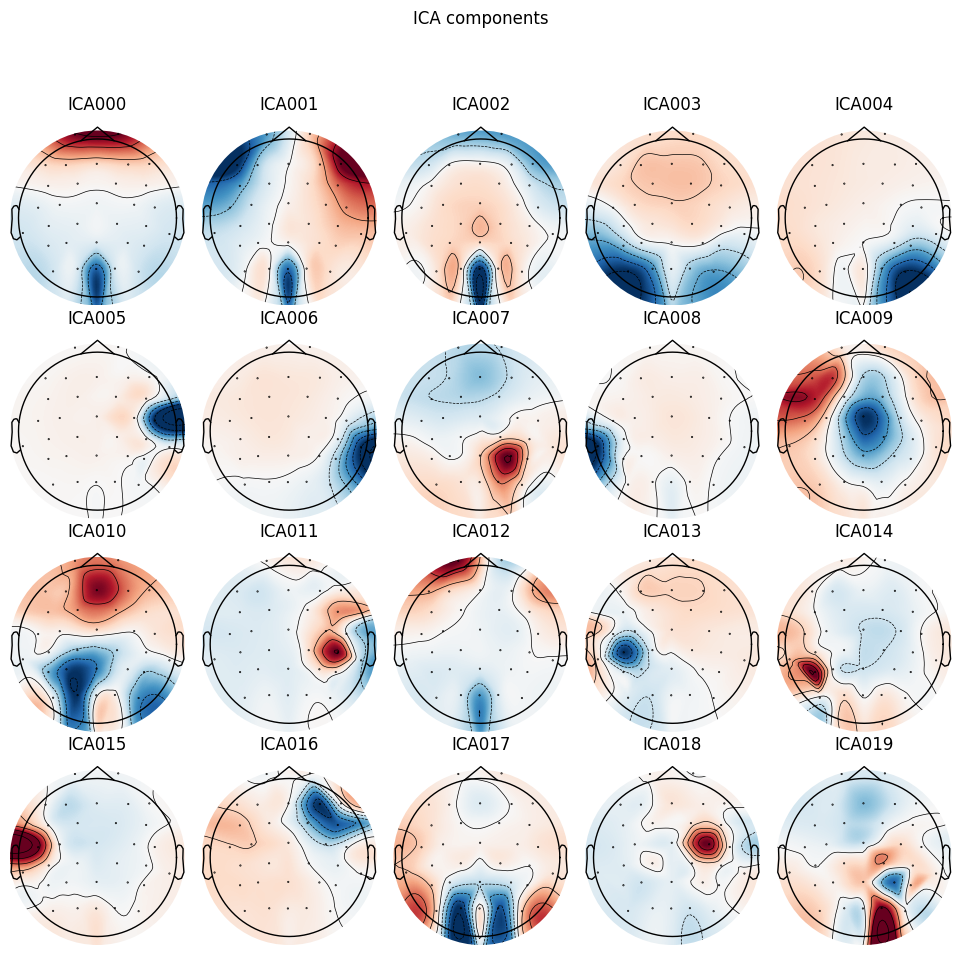

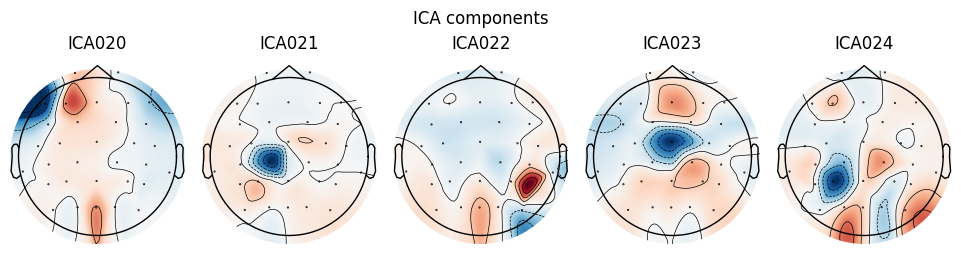

[<MNEFigure size 975x967 with 20 Axes>, <MNEFigure size 975x260.5 with 5 Axes>]

In [10]:
ica_obj.plot_components(picks=None,show=True, inst=mne_raw)


The first component is the eye blink movement contribution to the signal. As we expected the contribution is greater in electrodes closer to the eyes. It's also possible to see more deeply the time/frequency information of the component.

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
90 matching events found
No baseline correction applied
0 projection items activated


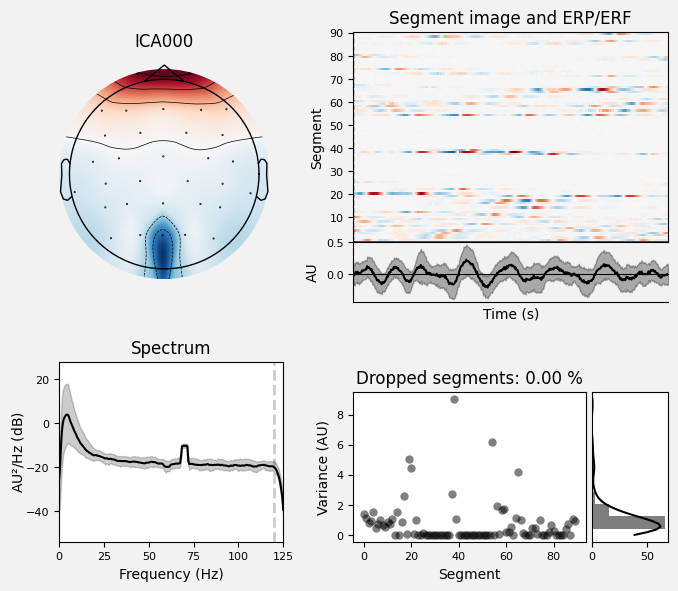

[<Figure size 700x600 with 6 Axes>]

In [11]:
ica_obj.plot_properties(mne_raw, picks=[0], show=True)

In [ ]:
pip install mne_icalabel

In [ ]:
from mne_icalabel import label_components

ic_labels = label_components(mne_raw, ica_obj, method="iclabel")
labels = ic_labels["labels"]

In [15]:
labels

['eye blink',
 'other',
 'other',
 'brain',
 'brain',
 'muscle artifact',
 'other',
 'brain',
 'heart beat',
 'brain',
 'brain',
 'brain',
 'brain',
 'brain',
 'brain',
 'other',
 'brain',
 'brain',
 'brain',
 'other',
 'other',
 'brain',
 'other',
 'brain',
 'other']

Now, to remove the blink movement artefact from the data, we just reconstruct the signal without this specific component. This means recovering the time series without the patterns associated with the artifact.

### Conclusion
In conclusion, Independent Component Analysis (ICA) is a powerful data-driven tool, that assumes non-gaussian data and linear relationships between source and signals to seek statistically independent components. ICA allows us to separate different contributions to the data, making it particularly useful in scenarios where noise or unwanted signals need to be isolated. In the case of EEG data, ICA can identify and remove motion artifacts like eye blink movements, which can contaminate the neural signal.